# 4: Signal Reconstruction and Denoising

Eva Dyer, BMED 6517

The aim of this module is to introduce different techniques for signal reconstruction and compression, and also provide some introduction to the analysis of time-Series and image data.

The topics include:

- Time-series data and FFT
- Representing image data
- Image Compression
- Denoising and filtering

_____

#### 1. Time-series data

In this notebook, we will explore ways to extract features from time-series data and images.

An outline:
- Introduction to time-series and spatial data and their representation in Python
- FFT: Extracting frequency representations from data in 1D
- Filtering through operations in the frequency domain
- Filtering through convolution in the time domain

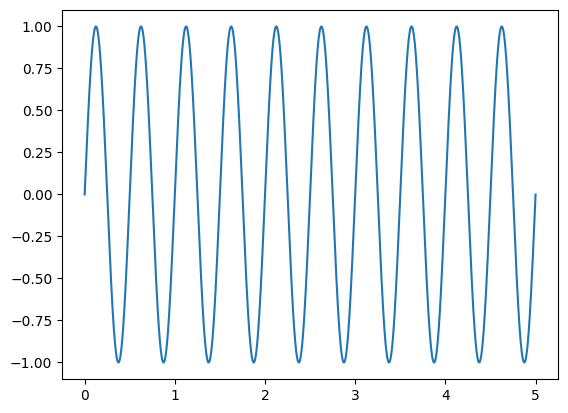

In [1]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

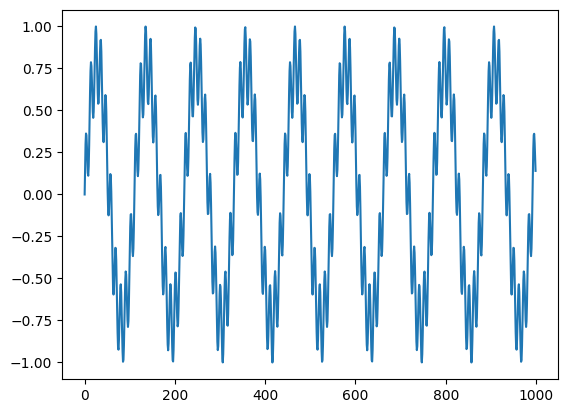

In [2]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone
normalized_tone = (mixed_tone / mixed_tone.max())

plt.plot(normalized_tone[:1000])
plt.show()

#### 2. Fourier Analysis (FFT)


1. Project into frequency domain:
$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-i \frac{2\pi}{N} nk}
\quad \text{for} \quad k = 0, 1, \ldots, N-1.
$$


2. Go back to the tim![Fourierop_rows_only.svg.png](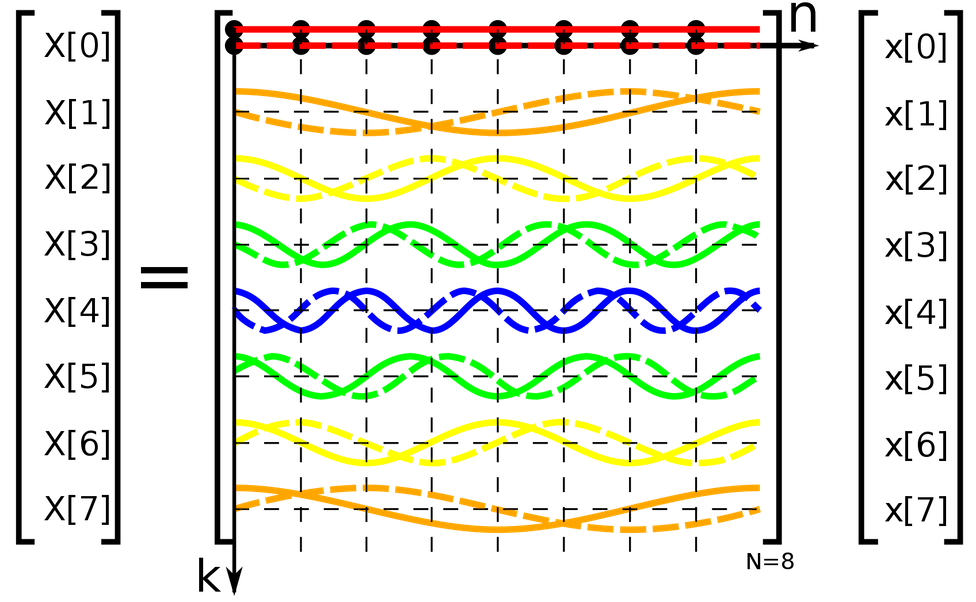![fouriermatrix.png](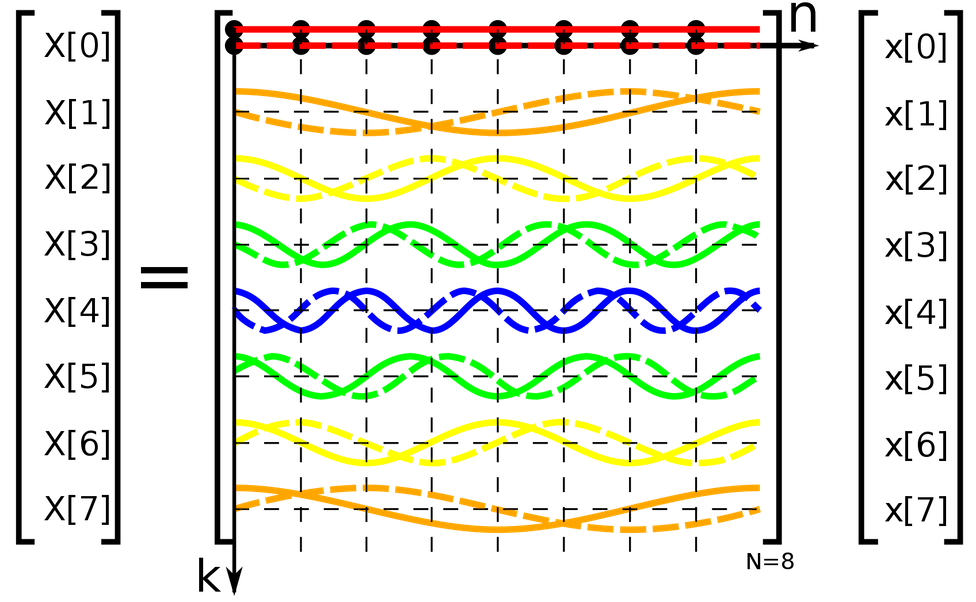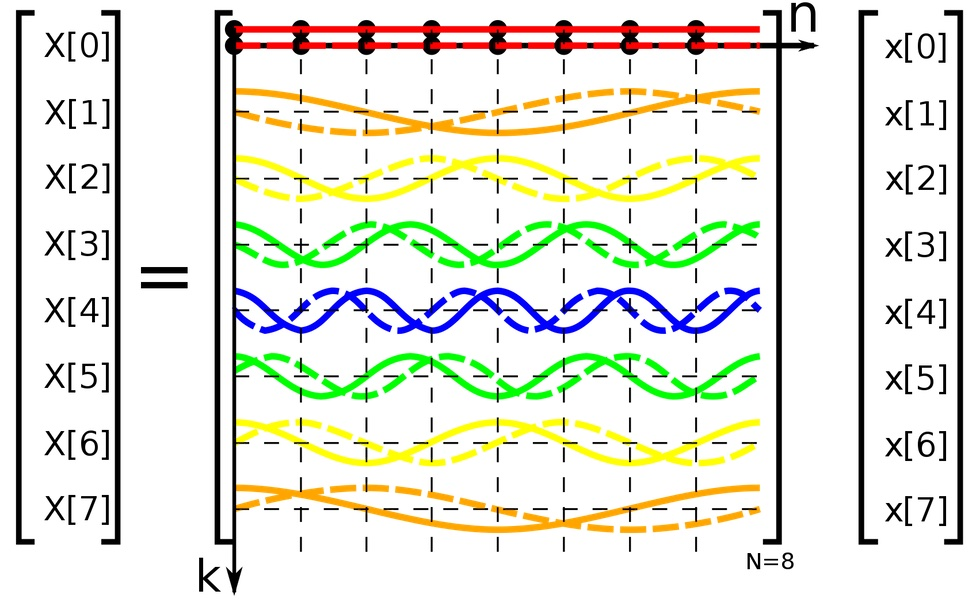))e-domain:

$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{i \frac{2\pi}{N} nk}
\quad \text{for} \quad n = 0, 1, \ldots, N-1.$$

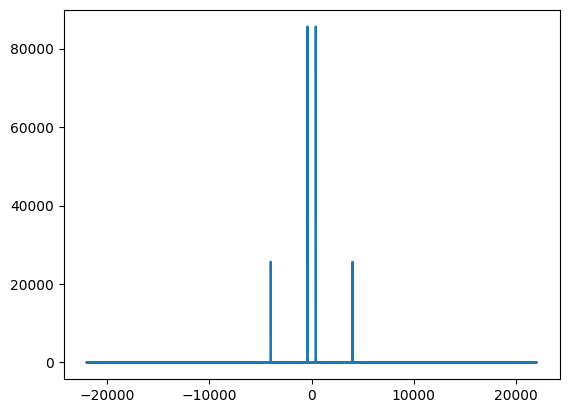

In [3]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(normalized_tone)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

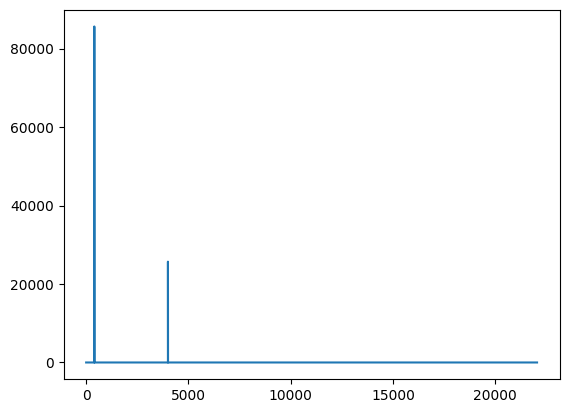

In [4]:
from scipy.fft import rfft, rfftfreq

# Note the extra 'r' at the front
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

**A matrix interpretation:**

We can also write our DFT and IDFT expansion and reconstruction using the following expressions:
$$
\varphi \leftarrow {\bf W} {\bf x}, \quad  {\bf x} \leftarrow {\bf W}^T \varphi,
$$
where the DFT matrix can be expressed as follows:
$$
\mathbf{W}_N = \left[ w_N^{jk} \right]_{j,k=0}^{N-1}
\quad \text{where} \quad w_N^{jk} = e^{-i \frac{2\pi}{N} jk}.
$$


##### 2.2. Filtering

An easy way to "filter" time-varying data is to set high-frequency components to zero.

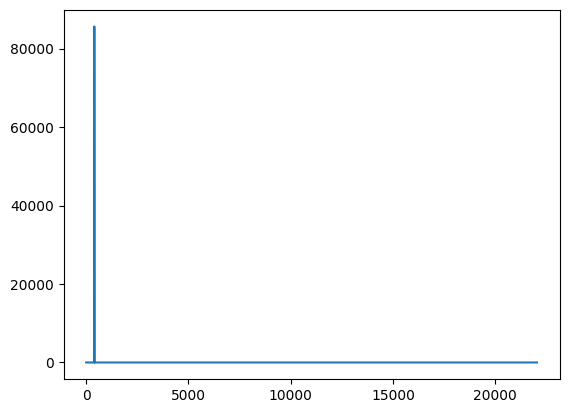

In [5]:
# The maximum frequency is half the sample rate
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Our target frequency is 4000 Hz
target_idx = int(points_per_freq * 4000)

yf[target_idx - 1 : target_idx + 2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

Now apply the inverse FFT to map the signal back to time domain

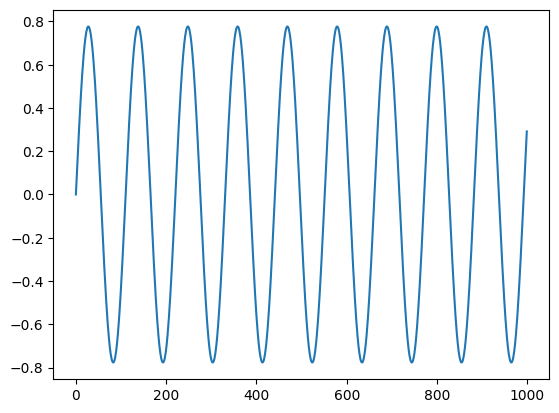

In [6]:
from scipy.fft import irfft

new_sig = irfft(yf)

plt.plot(new_sig[:1000])
plt.show()

**Challenge:**  

1. Write a small snippet of code to automatically extract the two oscillatory components (low-f and high-f) using either thresholding or other filtering operations.

2. After you filter your original signal into two, create a plot with both extracted components plotted as subfigures.

3. What happens if you add Gaussian noise to your original signal? Write a snippet of code to add Gaussian noise of some variance to your signal and apply your filtering algorithm.

4. Write a function for evaluating the accuracy of your reconstruction approach - this can be either in the frequency or time domain! Plot the accuracy of your method as a function of the amount of variance in the noise.

##### 2.4. Simple Moving Average Filter - Convolution in Time

There are deep connections between fourier transforms and convolutions! Convolutions also form the basis for a lot of modern neural networks and image processing.

Discrete-time convolution between a signal $x$ and kernel $h$ can be written as:
$$y[n] = (x * h)[n] = \sum_{k=-\infty}^{\infty} x[k] \cdot h[n - k]$$


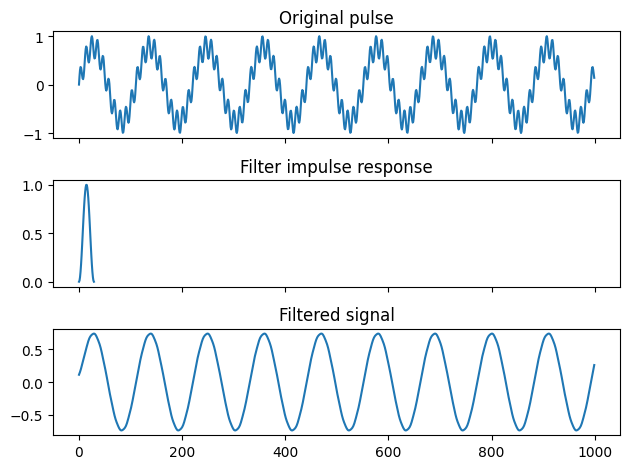

In [7]:
from scipy import signal
#sig = np.repeat([0., 1., 0.], 100)
win = signal.windows.hann(30)
filtered = signal.convolve(normalized_tone, win, mode='same') / sum(win)

import matplotlib.pyplot as plt
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(normalized_tone[:1000])
ax_orig.set_title('Original pulse')

ax_win.set_title('Filter impulse response')
ax_win.plot(win[:1000])

ax_filt.set_title('Filtered signal')
ax_filt.plot(filtered[:1000])
fig.tight_layout()
fig.show()

**Challenge:** What happens to the impulse response and filtered signal when you increase or decrease the width of the filter? Discuss the tradeoff between the two.

> Reply here

#### 3. Images (2D data)

##### 3.1. Image representation basics

A few key concepts:
- Pixel-based representation
- Spatial resolution: how large is each pixel?
- Grayscale value: quantization bit depth will dictate the number of unique values we can represent for each pixel

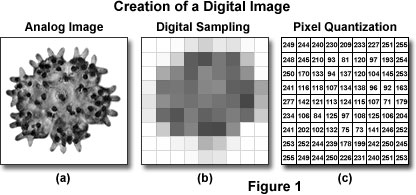

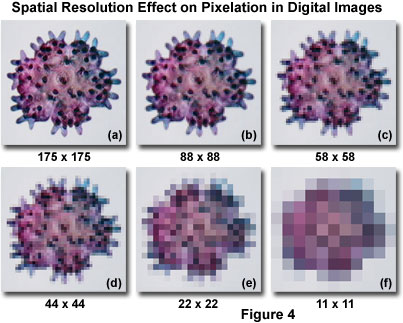

Examples from: https://hamamatsu.magnet.fsu.edu/articles/digitalimagebasics.html

##### 3.2. Denoising Example

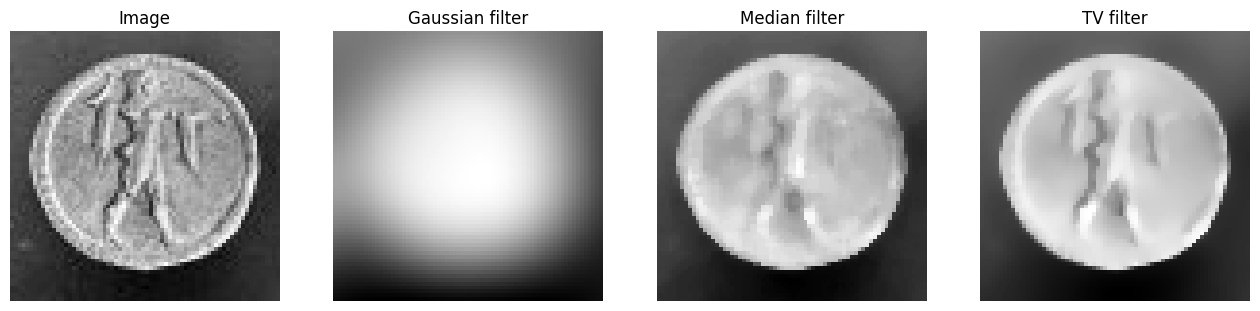

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import restoration

coins = data.coins()

# gaussian filter
gaussian_filter_coins = filters.gaussian(coins, sigma=10)

# median filter
med_filter_coins = filters.median(coins, np.ones((5, 5)))

# total variation filter
tv_filter_coins = restoration.denoise_tv_chambolle(coins, weight=0.1)

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(coins[10:80, 300:370], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Image')
plt.subplot(142)
plt.imshow(gaussian_filter_coins[10:80, 300:370], cmap='gray',
           interpolation='nearest')
plt.axis('off')
plt.title('Gaussian filter')
plt.subplot(143)
plt.imshow(med_filter_coins[10:80, 300:370], cmap='gray',
           interpolation='nearest')
plt.axis('off')
plt.title('Median filter')
plt.subplot(144)
plt.imshow(tv_filter_coins[10:80, 300:370], cmap='gray',
           interpolation='nearest')
plt.axis('off')
plt.title('TV filter')
plt.show()

#### 4. Image and Audio Compression



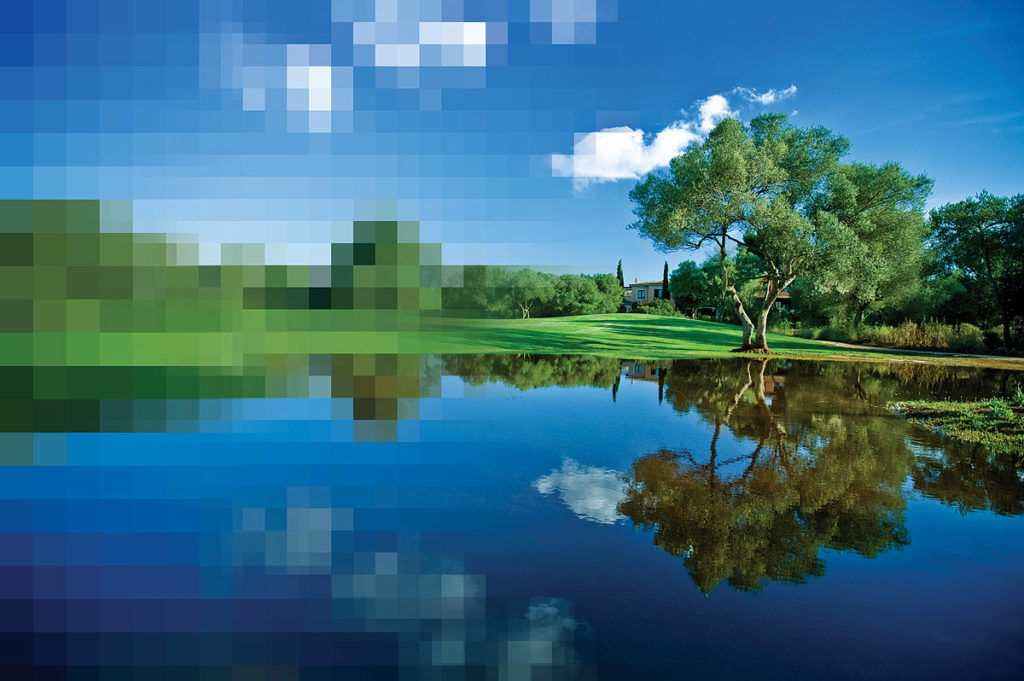

##### 4.1. Compression

JPEG compression (and MPEG in audio) both essentially build a simplified expansion (approximation) to an image or audio file as a combination of a set of fixed "basis" vectors:

$$ \min_{\bf x}~~  nnz( {\bf x} ) \quad \rm{subject~to} \quad \| {\bf y} - {\bf A} {\bf x} \|_2 \leq \epsilon ,$$

where:
- ${\bf y}$ is your measured data (e.g., unraveled image, or audio signal) (N dimensions),
- ${\bf A}$ is a matrix that contains a set of atoms or basis vectors that we can use to build an approximation (N x d matrix),
- ${\bf x}$ are the coefficients used in your expansion ($d$ dimensions),
- $nnz(\cdot)$ counts the number of elements in ${\bf A}$ that we use to approximation ${\bf y}$,
- $\epsilon$ is a user specified parameter that controls the error allowed in your approximation. In practice, when $\epsilon$ is too large, this produces visible artifacts in image compression.

In this case, we can write our approximation of ${\bf y}$ as a linear combination of a small number of elements in ${\bf A}$:
$$\widehat{{\bf y}} = \sum_{i \in \Omega}  {\bf a}_i {\bf x}(i),$$
where ${\bf a}_i$ is the $i^{\rm th}$ atom or column of ${\bf A}$, ${\bf x}(i)$ is the $i^{\rm th}$ entry of the coefficient vector ${\bf x}$, and $\Omega$ is an index set that indicates which atoms are used in the approximation. When there are only $k$ nonzeros in ${\bf x}$, we say that the signal has a $k$-sparse representation.

##### 4.2 Image Compression with the Discrete Cosine Transform (DCT)

Below, we will provide a simplified version of how JPEG compression works (roughly).

The method consists of the following steps:
- Extract 8x8 patches from an image
- Compute the DCT coefficients for each patch
- Select the top K largest coefficients for each patch
- Reconstruct all the patches using their top K coefficients
- Stack the patches back into their respective positions within the image

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from sklearn.datasets import load_sample_image
from scipy.fftpack import dctn, idctn
from scipy.spatial.distance import pdist

In [10]:
# helper functions to extract patches from an image
def im_to_patch(im, patch_size):
    return im.reshape(im.shape[0] // patch_size[0], patch_size[0], im.shape[1] // patch_size[1], patch_size[1]).swapaxes(1, 2).reshape(-1, patch_size[0], patch_size[1]).copy()

def patch_to_im(patches, patch_size, im_size):
    return patches.reshape(im_size[0] // patch_size[0], im_size[1] // patch_size[1], patch_size[0], patch_size[1]).swapaxes(1, 2).reshape(im_size).copy()

def im_to_vec(im, patch_size):
    return im.reshape(im.shape[0] // patch_size[0], patch_size[0], im.shape[1] // patch_size[1], patch_size[1]).swapaxes(1, 2).reshape(-1, patch_size[0] * patch_size[1]).copy()

def vec_to_im(vec, patch_size, im_size):
    return vec.reshape(im_size[0] // patch_size[0], im_size[1] // patch_size[1], patch_size[0], patch_size[1]).swapaxes(1, 2).reshape(im_size).copy()

# accuracy metric - MSE
def mse(original, noisy):
    return np.sum((original - noisy) ** 2)


Now, compute the k-sparse approximation of all of the 8x8 patches in the image.

In [11]:
china = load_sample_image('china.jpg').mean(axis=2)[:424, :] / 256

china_dct = dctn(im_to_patch(china, [8, 8]), axes=(1, 2))
x, y = np.mgrid[:8, :8]
n_coefs = 1
china_dct1 = np.where(np.logical_and(x < np.sqrt(n_coefs), y < np.sqrt(n_coefs)), china_dct, 0)
china_rc1 = patch_to_im(idctn(china_dct1, axes=(1, 2)), [8, 8], [424, 640]) / 256

n_coefs = 4
china_dct4 = np.where(np.logical_and(x < np.sqrt(n_coefs), y < np.sqrt(n_coefs)), china_dct, 0)
china_rc4 = patch_to_im(idctn(china_dct4, axes=(1, 2)), [8, 8], [424, 640]) / 256

n_coefs = 16
china_dct16 = np.where(np.logical_and(x < np.sqrt(n_coefs), y < np.sqrt(n_coefs)), china_dct, 0)
china_rc16 = patch_to_im(idctn(china_dct16, axes=(1, 2)), [8, 8], [424, 640]) / 256

n_coefs = 64
china_dct64 = np.where(np.logical_and(x < np.sqrt(n_coefs), y < np.sqrt(n_coefs)), china_dct, 0)
china_rc64 = patch_to_im(idctn(china_dct64, axes=(1, 2)), [8, 8], [424, 640]) / 256

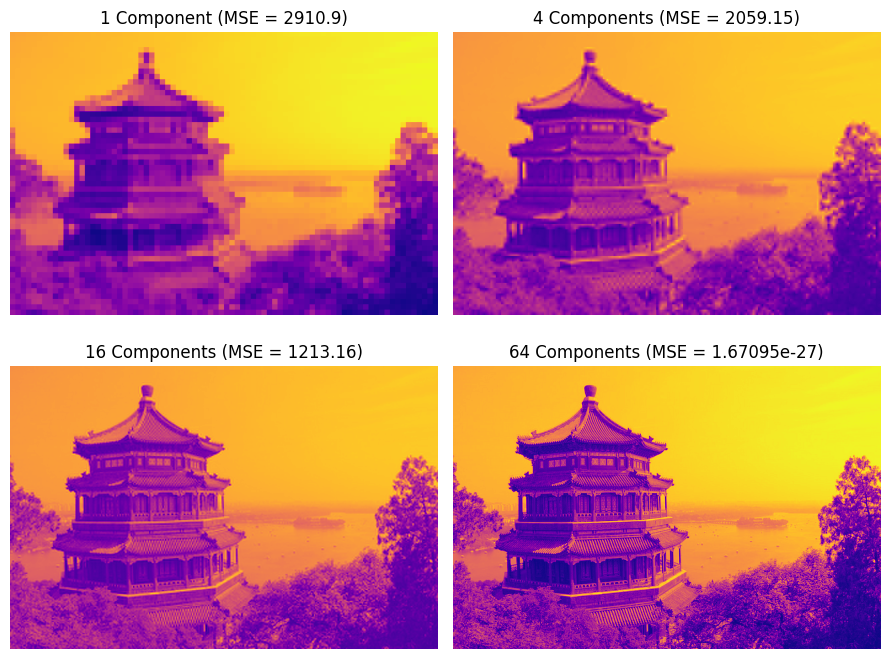

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes[0, 0].imshow(china_rc1, cmap='plasma')
axes[0, 0].set_axis_off()
axes[0, 0].set_title('1 Component (MSE = {:g})'.format(mse(china, china_rc1)))

axes[0, 1].imshow(china_rc4, cmap='plasma')
axes[0, 1].set_axis_off()
axes[0, 1].set_title('4 Components (MSE = {:g})'.format(mse(china, china_rc4)))

axes[1, 0].imshow(china_rc16, cmap='plasma')
axes[1, 0].set_axis_off()
axes[1, 0].set_title('16 Components (MSE = {:g})'.format(mse(china, china_rc16)))

axes[1, 1].imshow(china_rc64, cmap='plasma')
axes[1, 1].set_axis_off()
axes[1, 1].set_title('64 Components (MSE = {:g})'.format(mse(china, china_rc64)))
plt.tight_layout()
plt.show()

Let's visualize the basis vectors used to reconstruct each patch of the image:

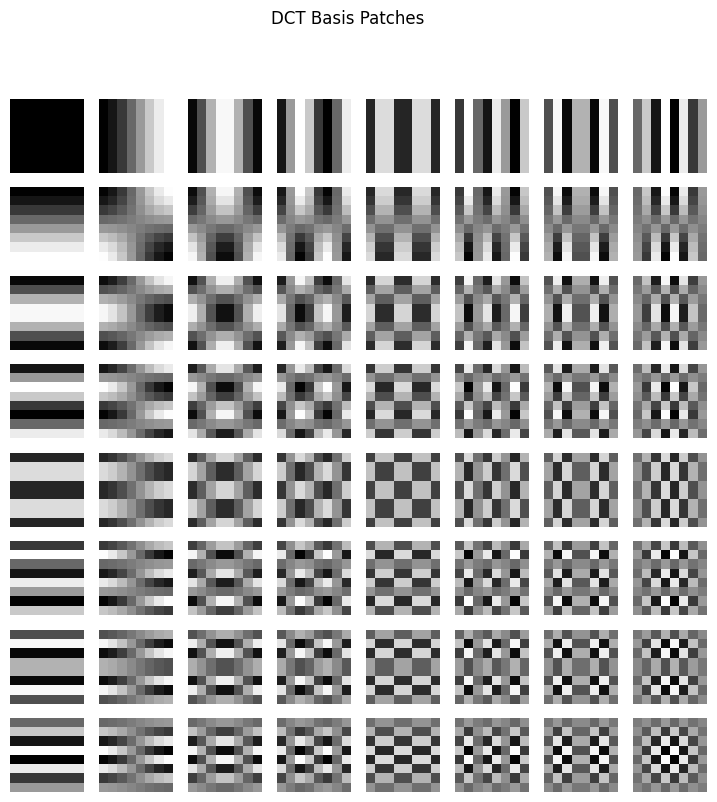

In [20]:
from matplotlib import colors

def make_dct_basis(coefs, patch_size):
    basis = np.empty(tuple(coefs) + tuple(patch_size))
    x, y = np.mgrid[:patch_size[0], :patch_size[1]]
    for i in range(coefs[0]):
        for j in range(coefs[1]):
            basis[i, j] = np.cos(np.pi * (x + .5) * i / coefs[0]) * np.cos(np.pi * (y + .5) * j / coefs[1])
    return basis

dct_vecs = make_dct_basis([8, 8], [8, 8])

fig, axes = plt.subplots(8, 8, figsize=(9, 9))
ims = []
for i in range(8):
    for j in range(8):
        ims += [axes[i, j].imshow(dct_vecs[i, j], cmap='binary')]
        axes[i, j].set_axis_off()
vmin = min([im.get_array().min() for im in ims])
vmax = max([im.get_array().max() for im in ims])
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in ims:
    im.set_norm(norm)
fig.suptitle('DCT Basis Patches')
plt.show()

**Challenge:**  Which DCT basis vectors will likely be used to represent the three selected regions (ROIs) within the image below? Provide your rationale and write a snippet of code to test your hypothesis.

In [14]:
# add code here

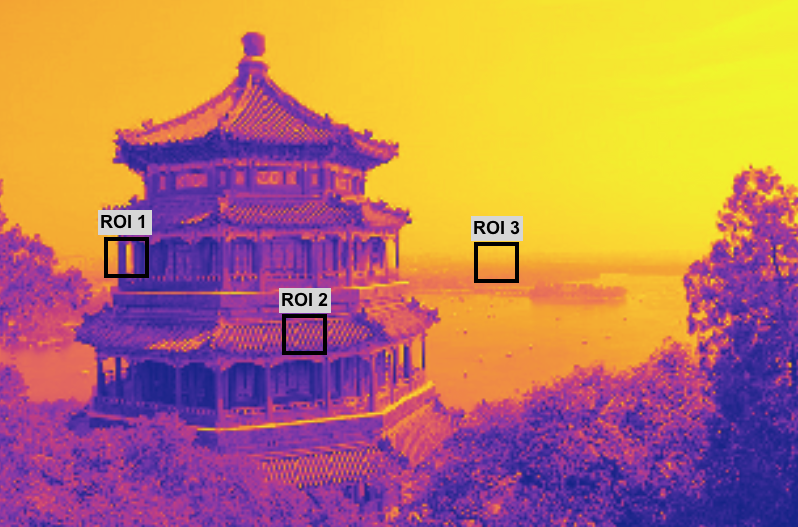

**Challenge:**
Write a snippet of code to visualize the top k most selected basis vectors in the image. The mean will always be selected for all patches, so you can exclude this basis vector from your analysis.

In [15]:
# add code here

#### 5. Learning a basis with PCA

Now, what if we don't know the right basis to use to expand our data??

In this case, we can **LEARN** a basis to use to efficiently represent our data (with few basis vectors). Principal components analysis gives a simple and effective starting point for learning a basis that best explains the variance in a collection of data. We will go into the details of PCA later in the course.

##### 5.1. Now, instead of using a pre-specified basis (the DCT), we will  learn a set of basis vectors with PCA and then use these to approximate the patches.

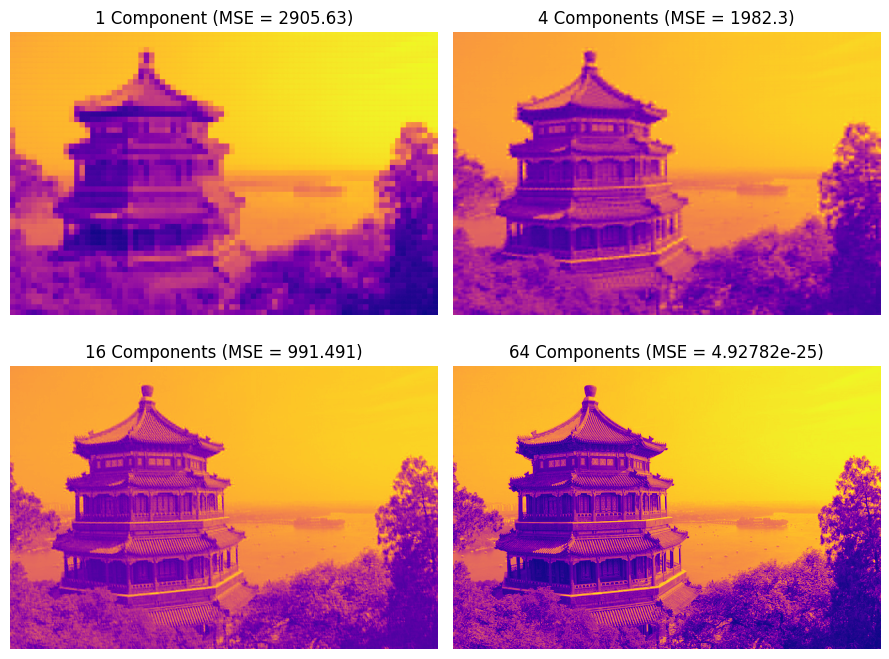

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
china_rc1 = vec_to_im(pca.inverse_transform(pca.fit_transform(im_to_vec(china, [8, 8]))), [8,8], [424, 640])

pca = PCA(n_components=4)
china_rc4 = vec_to_im(pca.inverse_transform(pca.fit_transform(im_to_vec(china, [8, 8]))), [8,8], [424, 640])

pca = PCA(n_components=16)
china_rc16 = vec_to_im(pca.inverse_transform(pca.fit_transform(im_to_vec(china, [8, 8]))), [8,8], [424, 640])

pca = PCA(n_components=64)
china_rc64 = vec_to_im(pca.inverse_transform(pca.fit_transform(im_to_vec(china, [8, 8]))), [8,8], [424, 640])

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes[0, 0].imshow(china_rc1, cmap='plasma')
axes[0, 0].set_axis_off()
axes[0, 0].set_title('1 Component (MSE = {:g})'.format(mse(china, china_rc1)))

axes[0, 1].imshow(china_rc4, cmap='plasma')
axes[0, 1].set_axis_off()
axes[0, 1].set_title('4 Components (MSE = {:g})'.format(mse(china, china_rc4)))

axes[1, 0].imshow(china_rc16, cmap='plasma')
axes[1, 0].set_axis_off()
axes[1, 0].set_title('16 Components (MSE = {:g})'.format(mse(china, china_rc16)))

axes[1, 1].imshow(china_rc64, cmap='plasma')
axes[1, 1].set_axis_off()
axes[1, 1].set_title('64 Components (MSE = {:g})'.format(mse(china, china_rc64)))
plt.tight_layout()
plt.show()

##### 5.2. Now let's visualize the basis functions learned by PCA.

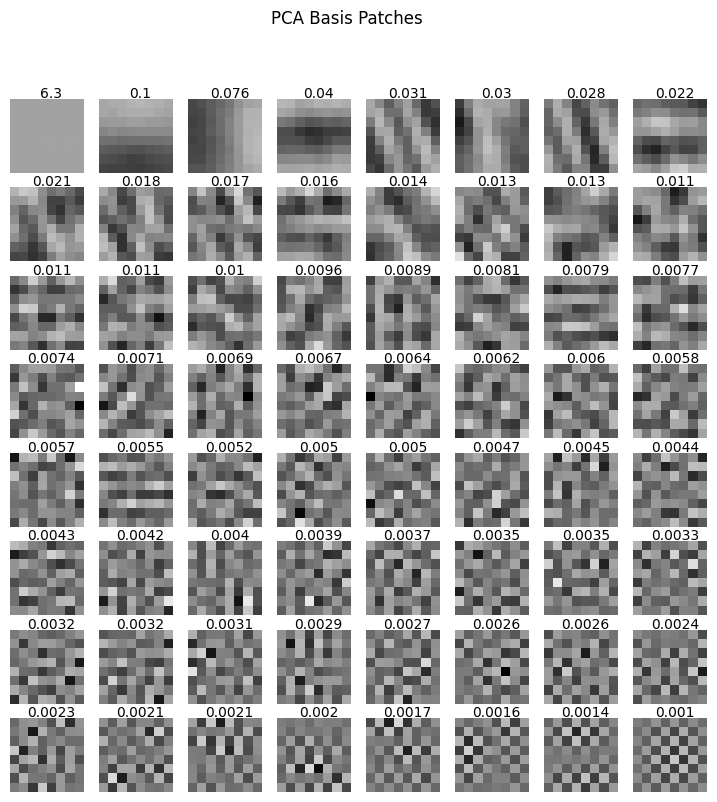

In [17]:
from matplotlib import colors

pca_vecs = pca.components_.reshape(8, 8, 8, 8)
pca_svs = pca.explained_variance_.reshape(8, 8)

fig, axes = plt.subplots(8, 8, figsize=(9, 9))
ims = []
for i in range(8):
    for j in range(8):
        ims += [axes[i, j].imshow(pca_vecs[i, j], cmap='binary')]
        axes[i, j].set_axis_off()
        axes[i, j].text(4, -.75, '{:.2g}'.format(pca_svs[i, j]), ha='center')
vmin = min([im.get_array().min() for im in ims])
vmax = max([im.get_array().max() for im in ims])
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in ims:
    im.set_norm(norm)
fig.suptitle('PCA Basis Patches')
plt.show()

**Challenge:**  Provide some discussion about the learned PCs. What are the salient features of the leading PCs? How does this result either align with or contradict your findings earlier about the most used basis functions?

> Reply here

#### 6. Denoising

##### 6.1. Connection between sparse approximation and denoising

Another important application of dimensionality reduction is for denoising data. Essentially, if we know that our datasets of interest typically have certain types of structure (for instance low frequency, or slowly varying signals) then we can use this fact to denoise data (removing high frequency components).

In the denoising setting, we can assume that our data consists of an underlying signal of interest that has been corrupted with noise:

$${\bf y} = {\bf s} + {\bf n}.$$

We will revisit our earlier equation:
$$ \min_{\bf x}~~  nnz( {\bf x} ) \quad \rm{subject~to} \quad \| {\bf y} - {\bf A} {\bf x} \|_2 \leq \epsilon ,$$

We can use this approach to find a simplified view of our signal of interest ${\bf s} = {\bf A} {\bf x}$, but in this case, we'd like to try to absorb the noise component ${\bf n}$ into our approximation error signal, ${\bf e} = {\bf y} - {\bf A}{\bf x}$. To make sure that happens, we need to ensure that the structure present in ${\bf s}$ is well matched to ${\bf A}$ and that the noise signal is not sufficiently similar in its structure when compared with ${\bf A}$.

##### 6.2. Denoising from clean data

In this first example, we denoise an image by using the basis vectors we learned (via PCA) for the clean image in the previous example.

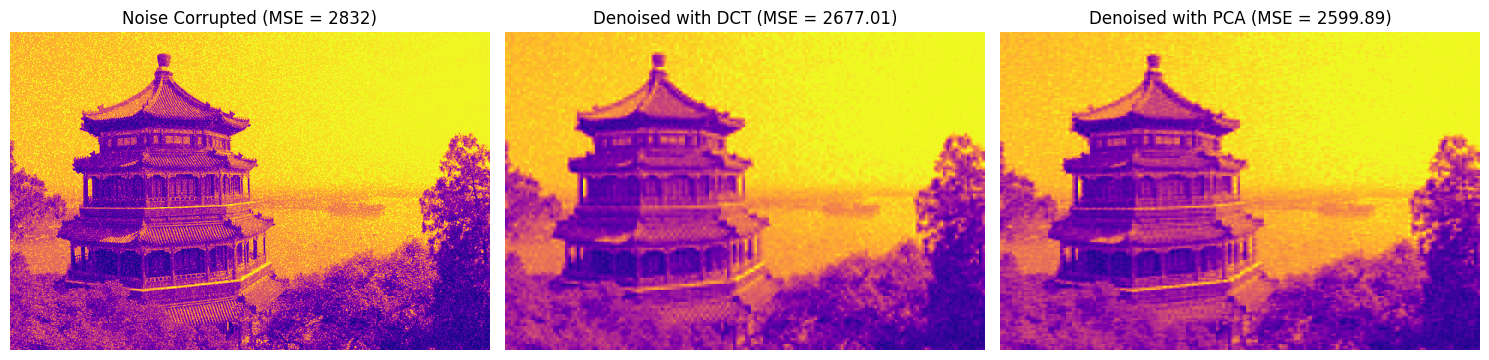

In [18]:
rng = np.random
china_noisy = (china + .25 * np.where(rng.randint(0, 6, china.shape) > 0, 0, 1)).clip(max=255)

n_coefs = 4
china_dct = dctn(im_to_patch(china_noisy, [8, 8]), axes=(1, 2))
china_dct = np.where(np.logical_and(x < np.sqrt(n_coefs), y < np.sqrt(n_coefs)), china_dct, 0)
china_dct_dn = patch_to_im(idctn(china_dct, axes=(1, 2)), [8, 8], [424, 640]) / 256

pca = PCA(n_components=n_coefs).fit(im_to_vec(china, [8, 8]))
china_pca_dn = vec_to_im(pca.inverse_transform(pca.transform(im_to_vec(china_noisy, [8, 8]))), [8, 8], [424, 640])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ims += [axes[0].imshow(china_noisy, cmap='plasma')]
axes[0].set_title('Noise Corrupted (MSE = {:g})'.format(mse(china, china_noisy)))
axes[0].set_axis_off()
ims += [axes[1].imshow(china_dct_dn, cmap='plasma')]
axes[1].set_title('Denoised with DCT (MSE = {:g})'.format(mse(china, china_dct_dn)))
axes[1].set_axis_off()
ims += [axes[2].imshow(china_pca_dn, cmap='plasma')]
axes[2].set_title('Denoised with PCA (MSE = {:g})'.format(mse(china, china_pca_dn)))
axes[2].set_axis_off()
norm = colors.Normalize(vmin=china.min(), vmax=china.max())
for im in ims:
    im.set_norm(norm)
plt.tight_layout()
plt.show()

##### 6.3. Denoising from noisy data

If all we have is a noisy image, PCA can still be used to denoise it, but the results typically won't look so nice:

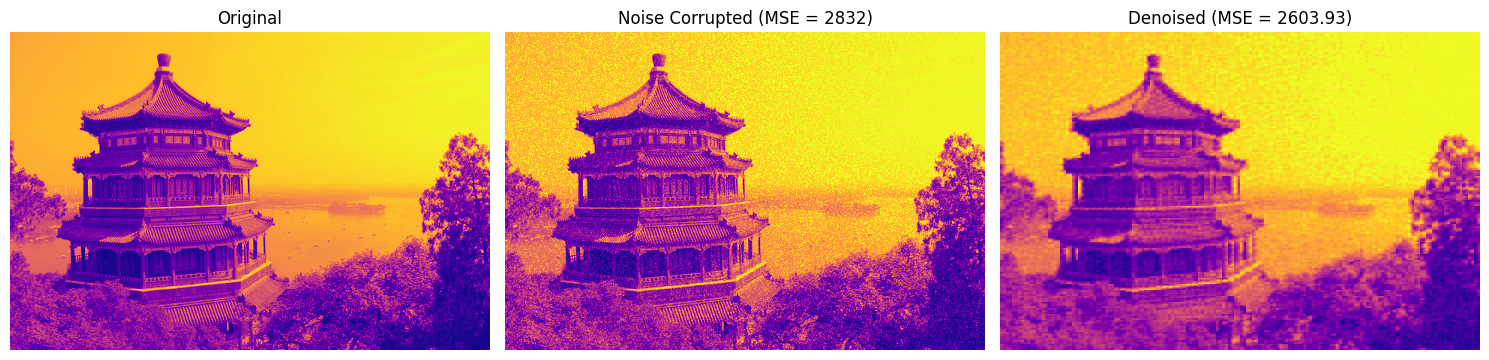

In [19]:
pca = PCA(n_components=4)
china_denoised = patch_to_im(pca.inverse_transform(pca.fit_transform(im_to_patch(china_noisy, [8, 8]).reshape([-1, 64]))).reshape([-1, 8, 8]), [8, 8], [424, 640])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ims += [axes[0].imshow(china, cmap='plasma')]
axes[0].set_axis_off()
axes[0].set_title('Original')

ims += [axes[1].imshow(china_noisy, cmap='plasma')]
axes[1].set_axis_off()
axes[1].set_title('Noise Corrupted (MSE = {:g})'.format(mse(china, china_noisy)))

ims += [axes[2].imshow(china_denoised, cmap='plasma')]
axes[2].set_axis_off()
axes[2].set_title('Denoised (MSE = {:g})'.format(mse(china, china_denoised)))
norm = colors.Normalize(vmin=china.min(), vmax=china.max())
for im in ims:
    im.set_norm(norm)
plt.tight_layout()

#### Resources

**Signal processing:**

- Tutorial on fft in scipy: https://docs.scipy.org/doc/scipy/tutorial/fft.html
- Scipy signal processing: https://docs.scipy.org/doc/scipy/reference/signal.html

**Images:**
- Local histogram equalization in Skimage: https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_local_equalize.html#sphx-glr-auto-examples-color-exposure-plot-local-equalize-py

Contributors: Max Dabagia, Mehdi Azabou, Eva Dyer